# Nearest neighbour for handwritten digit recognition

In this notebook I am implementing a nearest neighbour classification system in the goal to recognise handwritten digits.

I will first implement an algorithm myself, and then I will use pre-existing methods to compare their efficiency.

To do so I will use a part of the MNIST dataset.

## 1. Preparing datas

First I need to prepare the datas I will work on. I will use a part of the MNIST dataset : a training set of 7500 examples (instead of 60000) and a test set of 1000 (instead of 10000). 

The two samples contain the same number of each digit.

I'm using only a part of the dataset because de nearest neighbour classification isn't a very efficient system.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import time

# Load the training set
train_data = np.load('MNIST/train_data.npy')
train_labels = np.load('MNIST/train_labels.npy')

# Load the testing set
test_data = np.load('MNIST/test_data.npy')
test_labels = np.load('MNIST/test_labels.npy')

In [2]:
# Compute the number of examples of each digit
train_digits, train_counts = np.unique(train_labels, return_counts=True)
print("Training set distribution:")
print(dict(zip(train_digits, train_counts)))

test_digits, test_counts = np.unique(test_labels, return_counts=True)
print("Test set distribution:")
print(dict(zip(test_digits, test_counts)))

Training set distribution:
{0: 750, 1: 750, 2: 750, 3: 750, 4: 750, 5: 750, 6: 750, 7: 750, 8: 750, 9: 750}
Test set distribution:
{0: 100, 1: 100, 2: 100, 3: 100, 4: 100, 5: 100, 6: 100, 7: 100, 8: 100, 9: 100}


2 methods that will allow me to visualize the digits and show their labels

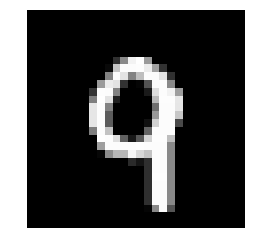

Label : 9


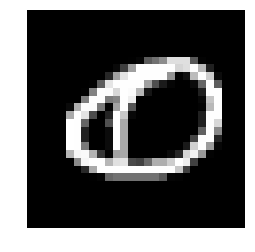

Label : 0


In [3]:
def show_digit(x):
    plt.axis('off')
    plt.imshow(x.reshape((28,28)), cmap=plt.cm.gray)
    plt.show()

def vis_image(index, dataset='train'):
    if(dataset=='train'):
        show_digit(train_data[index])
        label = train_labels[index]
    else:
        show_digit(test_data[index])
        label = test_labels[index]
    print("Label : " + str(label))

## View the first data point in the training set
vis_image(0, "train")

## Now view the first data point in the test set
vis_image(0, "test")

## 2. Implemetation

Now that I have a simple access to the datas and that I can visualize what I want I can begin the implementation of a brute force nearest neighbour classification.

I will implement two brute force algorithms, the first using a L2 distance function and the second using a L1 distance function. The results should be slightly different.

### 2.1. Generic functions

In [4]:
# The function that find the nearest neighbour given a distance function
def find_nn(x, dist_fun):
    distances = [dist_fun(x,train_data[i]) for i in range(len(train_labels))]
    return np.argmin(distances)

# The function that returns the guessed label given a distance function
def nn_classifier(x, dist_fun):
    index = find_nn(x, dist_fun)
    return train_labels[index]

# The function that returns an array of all the predicted values given a distance function
def nn(dist_fun):
    predicted_values = np.array([nn_classifier(test_data[i], dist_fun) for i in range(len(test_labels))])
    return predicted_values

### 2.2. Euclidean distance (L2)

In [5]:
# The L2 distance function
def square_l2_dist(x,y):
    return np.sum(np.square(x-y))

Test of the L2 nearest neighbour classification

In [6]:
# Predict on each test data point and timer
t_before = time.time()
test_predictions_l2 = nn(square_l2_dist)
t_after = time.time()

# Compute the error
err_positions = np.not_equal(test_predictions_l2, test_labels)
error = float(np.sum(err_positions))/len(test_labels)

print('Error of L2 nearest neighbor classifier : ', error)
print('Classification time : ', t_after - t_before)

Error of L2 nearest neighbor classifier :  0.046
Classification time :  46.23720693588257


As we can see here, the error rate is 4.6% using an euclidean distance, it's a pretty good result as this classification method is extremely simple.

### 2.3. Taxicab distance (L1)

In [7]:
# The L1 distance function
def square_l1_dist(x,y):
    return np.sum(np.abs(x-y))

In [8]:
# Predict on each test data point and timer
t_before = time.time()
test_predictions_l1 = nn(square_l1_dist)
t_after = time.time()

# Compute the error
err_positions = np.not_equal(test_predictions_l1, test_labels)
error = float(np.sum(err_positions))/len(test_labels)

print('Error of L1 nearest neighbor classifier : ', error)
print('Classification time : ', t_after - t_before)

Error of L1 nearest neighbor classifier :  0.056
Classification time :  42.40626907348633


The error rate is 5.6% using a taxicab distance, it's slightly less precise than with a L2 distance but the classification time is little bit lower.

## 3. Comparaison with better functions

### 3.1. BallTree method

In [9]:
from sklearn.neighbors import BallTree

# Build nearest neighbor structure on training data
t_before = time.time()
ball_tree = BallTree(train_data)
t_after = time.time()

print("Time to build data structure : ", t_after - t_before)

# Get nearest neighbor predictions on testing data
t_before = time.time()
test_neighbors = np.squeeze(ball_tree.query(test_data, k=1, return_distance=False))
ball_tree_predictions = train_labels[test_neighbors]
t_after = time.time()

print("Time to classify test set : ", t_after - t_before)

print("Ball tree produces same predictions as L2 ? ", np.array_equal(test_predictions_l2,ball_tree_predictions))

Time to build data structure :  0.4631025791168213
Time to classify test set :  8.949438095092773
Ball tree produces same predictions as L2 ?  True


In [10]:
from sklearn.neighbors import KDTree

# Build nearest neighbor structure on training data
t_before = time.time()
kd_tree = KDTree(train_data)
t_after = time.time()

print("Time to build data structure : ", t_after - t_before)

# Get nearest neighbor predictions on testing data
t_before = time.time()
test_neighbors = np.squeeze(kd_tree.query(test_data, k=1, return_distance=False))
kd_tree_predictions = train_labels[test_neighbors]
t_after = time.time()

print("Time to classify test set : ", t_after - t_before)

print("KD tree produces same predictions as L2 ? ", np.array_equal(test_predictions_l2,kd_tree_predictions))

Time to build data structure :  0.4234342575073242
Time to classify test set :  10.94090747833252
KD tree produces same predictions as L2 ?  True


As we can see above those two methods are way more efficient than a brute force algorithm, but the results are
the same because those two methods are using a L2 function too.